## How to forecast time series in BigQuery ML

This notebook accompanies the article
[How to do time series forecasting in BigQuery](https://docs.google.com/document/d/1E1gSkgWAY-SyJ2ZKa34i24w9XlY6lEX5DHirAhMv7MM/edit#)

## Install library and extensions if needed

You don't need to do this if you use AI Platform Notebooks

In [2]:
#!pip install google-cloud-bigquery
%load_ext google.cloud.bigquery

## Helper plot functions

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_historical_and_forecast(input_timeseries, timestamp_col_name, data_col_name, forecast_output=None, actual=None):
  input_timeseries = input_timeseries.sort_values(timestamp_col_name)    

  plt.figure(figsize=(20,6))
  plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
  plt.xlabel(timestamp_col_name)
  plt.ylabel(data_col_name)

  if forecast_output is not None:
    forecast_output = forecast_output.sort_values('forecast_timestamp')
    forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
    x_data = forecast_output['forecast_timestamp']
    y_data = forecast_output['forecast_value']
    confidence_level = forecast_output['confidence_level'].iloc[0] * 100
    low_CI = forecast_output['confidence_interval_lower_bound']
    upper_CI = forecast_output['confidence_interval_upper_bound']
    # Plot the data, set the linewidth, color and transparency of the
    # line, provide a label for the legend
    plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')
    # Shade the confidence interval
    plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4, label = str(confidence_level) + '% confidence interval')

  # actual
  if actual is not None:
    actual = actual.sort_values(timestamp_col_name)
    plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')   

  # Display legend
  plt.legend(loc = 'upper center', prop={'size': 16})

## Plot the time series

The first step, as with any machine learning problem is to gather the training data and explore it. Assume that we have the data on rentals until mid-June of 2015 and we'd like to predict for the rest of the month. We can gather the past 6 weeks of data using

In [2]:
%%bigquery df
SELECT
   CAST(EXTRACT(date from start_date) AS TIMESTAMP) AS date
   , COUNT(*) AS numrentals
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
GROUP BY date
HAVING date BETWEEN '2015-05-01' AND '2015-06-15'
ORDER BY date

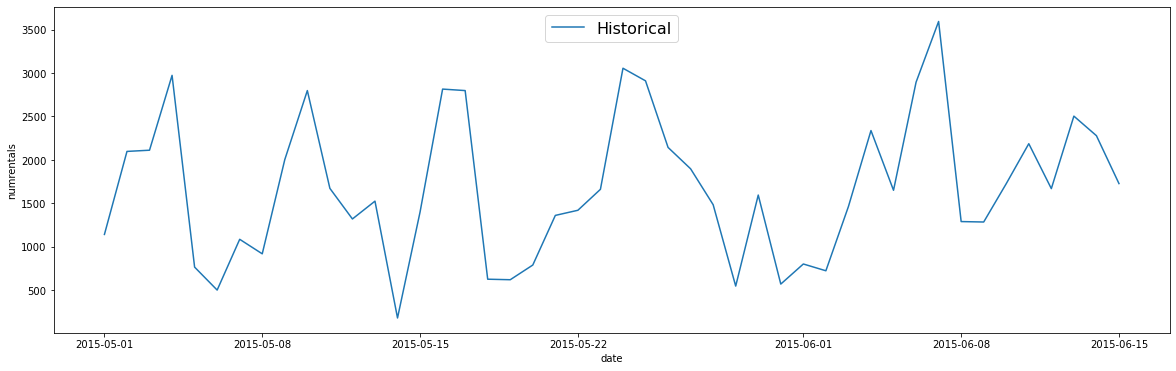

In [3]:
plot_historical_and_forecast(df, 'date', 'numrentals');

## Train ARIMA model

We can use this data to train an ARIMA model, telling BigQuery which column is the data column and which one the timestamp column:

In [5]:
!bq ls ch09eu || bq mk --location EU ch09eu

    tableId      Type    Labels   Time Partitioning   Clustered Fields  
 -------------- ------- -------- ------------------- ------------------ 
  stationstats   TABLE                                                  


In [4]:
%%bigquery
CREATE OR REPLACE MODEL ch09eu.numrentals_forecast
OPTIONS(model_type='ARIMA',
        time_series_data_col='numrentals',
        time_series_timestamp_col='date') AS
SELECT
   CAST(EXTRACT(date from start_date) AS TIMESTAMP) AS date
   , COUNT(*) AS numrentals
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
GROUP BY date
HAVING date BETWEEN '2015-05-01' AND '2015-06-15'

""


We can get the forecast data using:

In [6]:
%%bigquery fcst
SELECT * FROM ML.FORECAST(MODEL ch09eu.numrentals_forecast, 
                  STRUCT(14 AS horizon, 0.9 AS confidence_level))

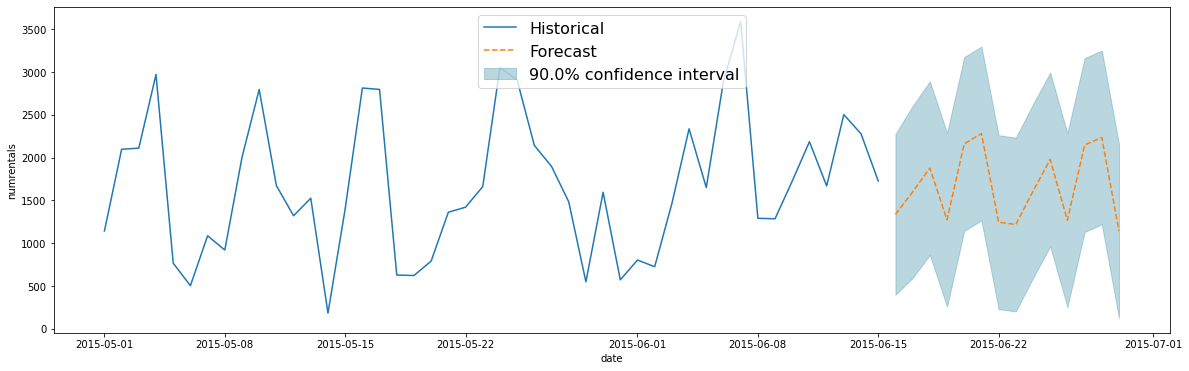

In [7]:
plot_historical_and_forecast(df, 'date', 'numrentals', fcst);

In [8]:
%%bigquery actual
SELECT
   CAST(EXTRACT(date from start_date) AS TIMESTAMP) AS date
   , COUNT(*) AS numrentals
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
GROUP BY date
HAVING date BETWEEN '2015-06-16' AND '2015-07-01'
ORDER BY date

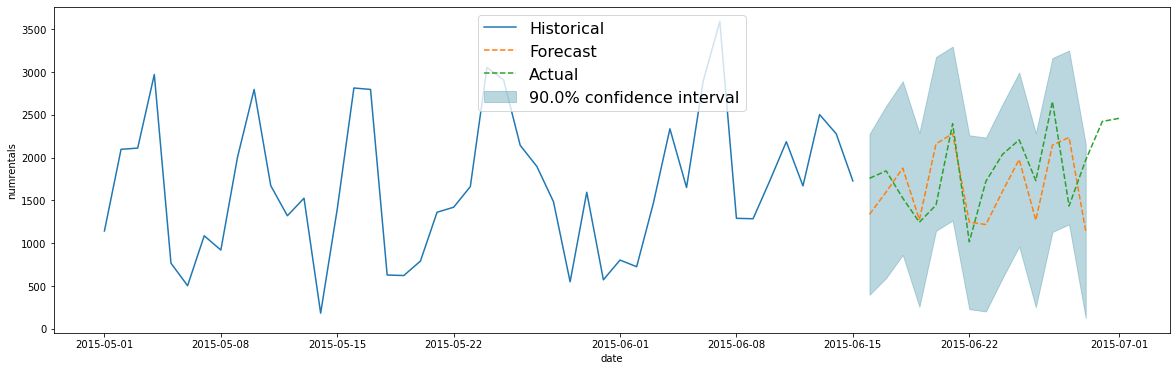

In [9]:
plot_historical_and_forecast(df, 'date', 'numrentals', fcst, actual);

## Forecasting a bunch of series

So far, I have been forecasting the overall rental volume for all the bicycle stations in Hyde Park. How do we predict the rental volume for each individual station? Use the time_series_id_col:

In [10]:
%%bigquery
CREATE OR REPLACE MODEL ch09eu.numrentals_forecast
OPTIONS(model_type='ARIMA',
        time_series_data_col='numrentals',
        time_series_timestamp_col='date',
        time_series_id_col='start_station_name') AS
SELECT
   start_station_name
   , CAST(EXTRACT(date from start_date) AS TIMESTAMP) AS date
   , COUNT(*) AS numrentals
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
GROUP BY start_station_name, date
HAVING date BETWEEN '2015-01-01' AND '2015-06-15'

""


Note that instead of training the series on 45 days (May 1 to June 15), I'm now training on a longer time period.
That's because the aggregate time series will tend to be smoother and much easier to predict than the time series
for individual stations. So, we have to show the model a longer trendline.

In [11]:
%%bigquery
SELECT * 
FROM ML.ARIMA_COEFFICIENTS(MODEL ch09eu.numrentals_forecast)
ORDER BY start_station_name

,start_station_name,ar_coefficients,ma_coefficients,intercept_or_drift
0,"Albert Gate, Hyde Park",[],"[-0.49088368033963203, -0.6176568052386862, 0....",1.412853
1,"Bayswater Road, Hyde Park",[],"[-0.5055044960988461, -0.6533856870089425, 0.7...",0.458325
2,"Cumberland Gate, Hyde Park","[0.46572442281908444, 0.038728300833856116, 0....",[],98.078419
3,"Hyde Park Corner, Hyde Park",[],"[-0.418727013951242, -0.6822008089408759, 0.68...",1.949161
4,"Knightsbridge, Hyde Park","[-0.09583012589735504, -0.6875368354421961]","[-0.4082895446969246, 0.7047333074348044, -0.7...",0.000000
5,"Park Lane , Hyde Park",[],"[-0.7635196093832379, -0.22456271727098703, 0....",0.000000
6,"Serpentine Car Park, Hyde Park",[],"[-0.46779787048999, 0.09840430711938741, -0.64...",0.696481
7,"Speakers' Corner 1, Hyde Park",[],"[-0.8757411297181149, -0.1308245794762758, 0.5...",1.173904
8,"Speakers' Corner 2, Hyde Park",[],"[-0.6093836513944061, -0.33001811760720823, 0....",1.033710
9,"Triangle Car Park, Hyde Park",[],"[-0.49240464920324234, -0.6251103034123127, 0....",0.932047


In [15]:
%%bigquery fcst
SELECT 
  * 
FROM ML.FORECAST(MODEL ch09eu.numrentals_forecast, 
                  STRUCT(14 AS horizon, 0.9 AS confidence_level))
ORDER By start_station_name, forecast_timestamp

In [16]:
%%bigquery df
SELECT
   start_station_name
   , CAST(EXTRACT(date from start_date) AS TIMESTAMP) AS date
   , COUNT(*) AS numrentals
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
GROUP BY start_station_name, date
HAVING date BETWEEN '2015-05-01' AND '2015-06-15'  -- this is just for plotting, hence we'll keep this 45 days.

In [17]:
%%bigquery actual
SELECT
   start_station_name
   , CAST(EXTRACT(date from start_date) AS TIMESTAMP) AS date
   , COUNT(*) AS numrentals
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
GROUP BY start_station_name, date
HAVING date BETWEEN '2015-06-16' AND '2015-07-01'

As you would expect, the aggregated time series over all the stations is much smoother and more predictable than the time series of just one station (the one station data will be more noisy). So, some forecasts will be better than others.

In [18]:
%%bigquery stations
SELECT DISTINCT start_station_name
FROM
  `bigquery-public-data`.london_bicycles.cycle_hire
WHERE start_station_name LIKE '%Hyde%'  -- all stations in Hyde Park
ORDER by start_station_name ASC

In [19]:
stations

,start_station_name
0,"Albert Gate, Hyde Park"
1,"Bayswater Road, Hyde Park"
2,"Cumberland Gate, Hyde Park"
3,"Hyde Park Corner, Hyde Park"
4,"Knightsbridge, Hyde Park"
5,"Park Lane , Hyde Park"
6,"Serpentine Car Park, Hyde Park"
7,"Speakers' Corner 1, Hyde Park"
8,"Speakers' Corner 2, Hyde Park"
9,"Triangle Car Park, Hyde Park"


Hyde Park Corner, Hyde Park


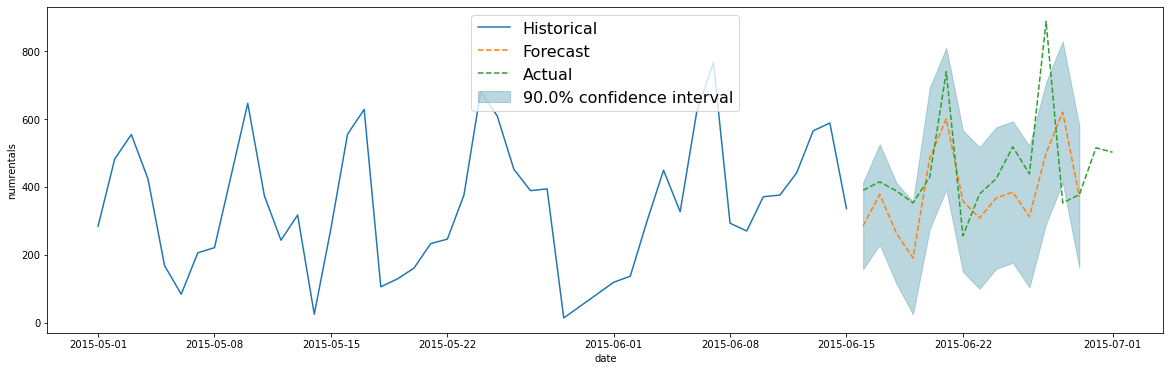

In [20]:
station = stations['start_station_name'].iloc[3] # Hyde Park Corner
print(station)
plot_historical_and_forecast(df[df['start_station_name']==station],
                             'date', 'numrentals',
                             fcst[fcst['start_station_name']==station], 
                             actual[actual['start_station_name']==station]);

Serpentine Car Park, Hyde Park


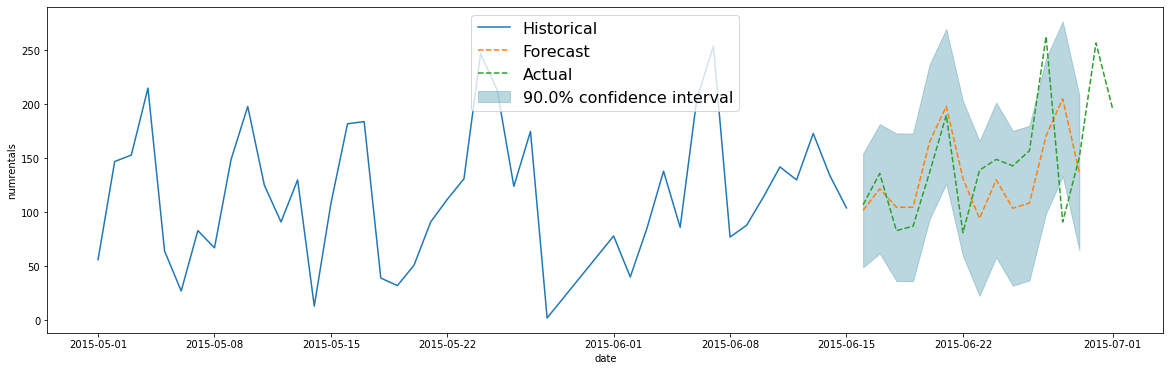

In [21]:
station = stations['start_station_name'].iloc[6] # Serpentine Car Park,
print(station)
plot_historical_and_forecast(df[df['start_station_name']==station],
                             'date', 'numrentals',
                             fcst[fcst['start_station_name']==station], 
                             actual[actual['start_station_name']==station]);

Knightsbridge, Hyde Park


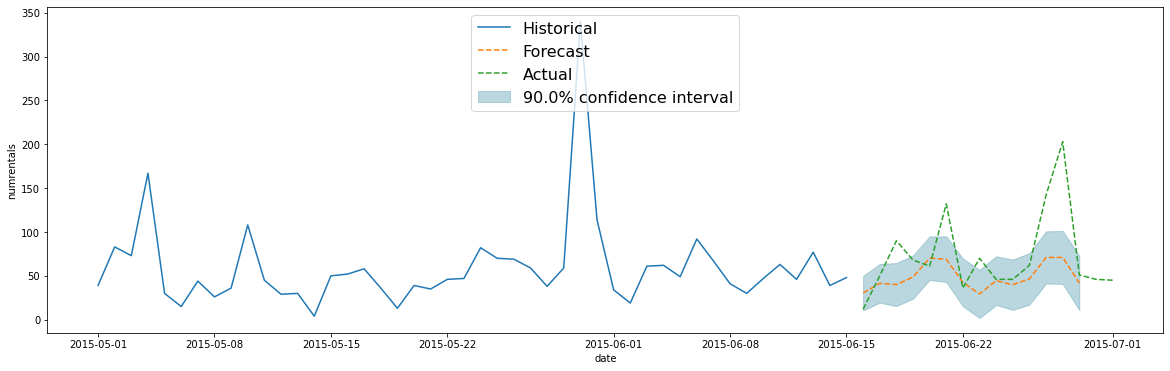

In [22]:
station = stations['start_station_name'].iloc[4] # Knightsbridge
print(station)
plot_historical_and_forecast(df[df['start_station_name']==station],
                             'date', 'numrentals',
                             fcst[fcst['start_station_name']==station], 
                             actual[actual['start_station_name']==station]);

## Evaluation

As you can see from the graphs above, the predictions accuracy varies by station. Can we gauge how good the prediction for a station is going to be?

In [23]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL ch09eu.numrentals_forecast)
ORDER BY variance DESC

,start_station_name,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods
0,"Hyde Park Corner, Hyde Park",0,1,5,True,-941.742040,1897.484081,5861.854351,[WEEKLY]
1,"Albert Gate, Hyde Park",0,1,5,True,-899.633452,1813.266905,3578.184945,[WEEKLY]
2,"Triangle Car Park, Hyde Park",0,1,5,True,-848.696501,1711.393003,1906.039953,[WEEKLY]
3,"Speakers' Corner 1, Hyde Park",0,1,5,True,-847.196087,1708.392173,1901.900795,[WEEKLY]
4,"Speakers' Corner 2, Hyde Park",0,1,5,True,-835.673511,1685.347023,1709.998829,[WEEKLY]
5,"Serpentine Car Park, Hyde Park",0,1,5,True,-796.360706,1606.721413,1011.930554,[WEEKLY]
6,"Wellington Arch, Hyde Park",2,1,3,True,-787.843165,1589.686330,918.048142,[WEEKLY]
7,"Cumberland Gate, Hyde Park",4,0,0,False,-766.529817,1545.059634,709.548860,[WEEKLY]
8,"Bayswater Road, Hyde Park",0,1,5,True,-704.437913,1422.875825,320.431339,[WEEKLY]
9,"Park Lane , Hyde Park",0,1,5,False,-647.577584,1307.155169,164.709806,[WEEKLY]


Note that Hyde Park Corner (#0 on the list) is expected to be worse than Serpentine Corner (#5 on the list). That does pan out. But we expected Knightsbridge (#10) to be the best overall, but it appears that this is a case where cycling activity really picked up in an unexpected way.

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License